In [13]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set Random Seed and Device Configuration
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Using CUDA (GPU) Available GPUs: {num_gpus}")
    
    # 显示所有可用 GPU 设备信息
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    device = torch.device("cpu")
    print("Using CPU (No GPU detected)")

# 显示最终选择的设备
print(f"Running on device: {device}")

Using CUDA (GPU) Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4080 SUPER
Running on device: cuda


In [14]:
df = pd.read_csv('./datasets/Housing.csv')
print(df.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [15]:
# 列表: mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea => yes/no
yesno_cols = ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]
for c in yesno_cols:
    df[c] = df[c].map({'yes': 1, 'no': 0})

# 列表: furnishingstatus => 有三种: furnished / semi-furnished / unfurnished
status_map = {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0}
df['furnishingstatus'] = df['furnishingstatus'].map(status_map)

# df['price'] = df['price'] / 1e4
# df['price'] = df['price'] / 1e5
# df['price'] = df['price'] / 1e6

price_scaler = StandardScaler()
df['price'] = price_scaler.fit_transform(df[['price']])

# **标准化 X 特征数据**
scaler = StandardScaler()

# 只对 `area` 特征进行标准化
df['area'] = scaler.fit_transform(df[['area']])  # 归一化特征

print("After conversion:\n", df.head())

After conversion:
       price      area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  4.566365  1.046726         4          2        3         1          0   
1  4.004484  1.757010         4          4        4         1          0   
2  4.004484  2.218232         3          2        2         1          0   
3  3.985755  1.083624         4          2        2         1          0   
4  3.554979  1.046726         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 2  
1                 2  
2                 1  
3                 2  
4    

In [16]:
# X: features, y: target
y = df['price'].values.astype(np.float32)
X = df.drop(columns=['price']).values.astype(np.float32)

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

# 转为 PyTorch Tensor
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).view(-1, 1)  # (N,) => (N,1) for regression

dataset = TensorDataset(X_tensor, y_tensor)

# 80/20 split
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(f"Total samples = {total_size}, train = {train_size}, val = {val_size}")

# DataLoader
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


Feature shape: (545, 12)
Target shape: (545,)
Total samples = 545, train = 436, val = 109


In [17]:
class HousingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1):
        super(HousingMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(0.1))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [18]:
def train_regression_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_samples = 0
    
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        batch_sz = Xb.size(0)
        total_loss += loss.item() * batch_sz
        total_samples += batch_sz
    
    avg_loss = total_loss / total_samples
    return avg_loss

In [19]:
def train_regression_epoch_r2(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    
    # 如果想算R²等，可以先收集预测和label
    preds_list = []
    labels_list = []
    
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, yb)
            
            batch_sz = Xb.size(0)
            total_loss += loss.item() * batch_sz
            total_samples += batch_sz
            
            preds_list.append(preds.cpu().numpy())
            labels_list.append(yb.cpu().numpy())
    
    avg_loss = total_loss / total_samples
    
    # 计算R²
    all_preds = np.concatenate(preds_list, axis=0).squeeze()
    all_labels = np.concatenate(labels_list, axis=0).squeeze()
    r2 = r2_score(all_labels, all_preds)
    
    return avg_loss, r2

In [20]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = [], []
    val_r2_list = []
    
    for epoch in range(num_epochs):
        # 训练
        train_loss = train_regression_epoch(model, train_loader, optimizer, criterion)
        
        # 验证
        val_loss, val_r2 = train_regression_epoch_r2(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_r2_list.append(val_r2)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE: {train_loss:.2f}, Val MSE: {val_loss:.2f}, Val R²: {val_r2:.2f}")
    
    return train_losses, val_losses, val_r2_list

In [21]:
input_dim = X.shape[1]
hidden_dims=[64, 32]
# hidden_dims=[128, 64, 32]
model = HousingMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=1).to(device)

# num_epochs = 20
# num_epochs = 50
num_epochs = 60
# num_epochs = 80
# num_epochs = 100
lr = 0.001
train_losses, val_losses, val_r2_list = train_model(
    model, train_loader, val_loader, num_epochs=num_epochs, lr=lr
)

Epoch [1/60], Train MSE: 0.99, Val MSE: 0.73, Val R²: 0.10
Epoch [2/60], Train MSE: 0.91, Val MSE: 0.68, Val R²: 0.15
Epoch [3/60], Train MSE: 0.85, Val MSE: 0.64, Val R²: 0.20
Epoch [4/60], Train MSE: 0.79, Val MSE: 0.60, Val R²: 0.26
Epoch [5/60], Train MSE: 0.71, Val MSE: 0.56, Val R²: 0.31
Epoch [6/60], Train MSE: 0.64, Val MSE: 0.52, Val R²: 0.35
Epoch [7/60], Train MSE: 0.56, Val MSE: 0.50, Val R²: 0.38
Epoch [8/60], Train MSE: 0.50, Val MSE: 0.49, Val R²: 0.39
Epoch [9/60], Train MSE: 0.47, Val MSE: 0.48, Val R²: 0.40
Epoch [10/60], Train MSE: 0.44, Val MSE: 0.48, Val R²: 0.41
Epoch [11/60], Train MSE: 0.42, Val MSE: 0.46, Val R²: 0.43
Epoch [12/60], Train MSE: 0.41, Val MSE: 0.43, Val R²: 0.47
Epoch [13/60], Train MSE: 0.39, Val MSE: 0.40, Val R²: 0.50
Epoch [14/60], Train MSE: 0.38, Val MSE: 0.39, Val R²: 0.52
Epoch [15/60], Train MSE: 0.37, Val MSE: 0.38, Val R²: 0.53
Epoch [16/60], Train MSE: 0.36, Val MSE: 0.37, Val R²: 0.54
Epoch [17/60], Train MSE: 0.35, Val MSE: 0.36, Va

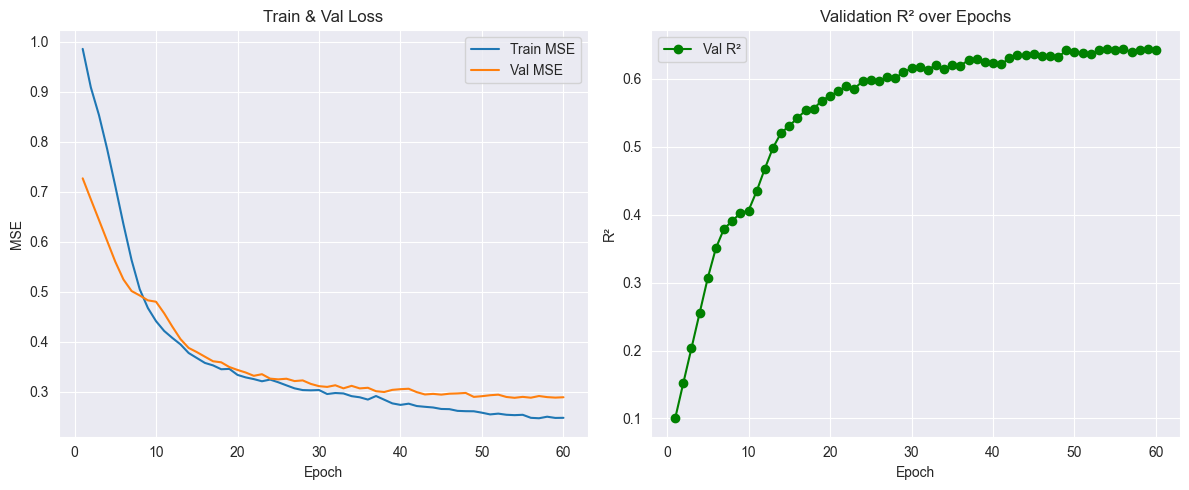

In [22]:
# Plot Loss vs. Epoch
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train MSE')
plt.plot(range(1, num_epochs+1), val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train & Val Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), val_r2_list, label='Val R²', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Validation R² over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for Xv, yv in val_loader:
        preds_v = model(Xv.to(device))
        all_preds.append(preds_v.cpu().numpy())
        all_targets.append(yv.cpu().numpy())

all_preds = np.concatenate(all_preds).squeeze()
all_targets = np.concatenate(all_targets).squeeze()

mse_val = mean_squared_error(all_targets, all_preds)
mae_val = mean_absolute_error(all_targets, all_preds)
r2_val = r2_score(all_targets, all_preds)

print(f"Final on Val => MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, R²: {r2_val:.2f}")

# 模型复杂度
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model Complexity:")
print(f" - Hidden layers: {hidden_dims}")
print(f" - Total trainable parameters: {total_params}")

Final on Val => MSE: 0.29, MAE: 0.41, R²: 0.64
Model Complexity:
 - Hidden layers: [64, 32]
 - Total trainable parameters: 2945
